In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import pyodbc
import sqlalchemy as sqlal
import pandas as pd
import numpy as np

In [2]:
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        if((user) or (password)):
            print ('Any given username or password will be ignored')
        engine = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        assert user, 'You must define a username'
        assert password, 'You must define a password'
        # For SQL Server authentication
        engine = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    return sqlal.create_engine(engine)

def connect_database(engine):
    try:
        conn = engine.connect()
        print('Connection successfully exablished')
        return conn
    except Exception as e:
        print(e)

def inspect_engine(engine):
    try:
        insp = sqlal.inspect(engine)
        return insp
    except Exception as e:
        print(e)
    

In [3]:
#engine = sqlal.create_engine('mssql+pyodbc://DESKTOP-JVC9C2F/AdventureWorks2022?driver=SQL Server?Trusted_Connection=yes')
engine= new_engine('mssql+pyodbc','DESKTOP-JVC9C2F','AdventureWorks2022')

In [7]:
connection= connect_database(engine)

Connection successfully exablished


In [8]:
inspector =inspect_engine(engine)
schemas = inspector.get_schema_names()
print(schemas)

['db_accessadmin', 'db_backupoperator', 'db_datareader', 'db_datawriter', 'db_ddladmin', 'db_denydatareader', 'db_denydatawriter', 'db_owner', 'db_securityadmin', 'dbo', 'guest', 'HumanResources', 'INFORMATION_SCHEMA', 'Person', 'Production', 'Purchasing', 'Sales', 'sys']


In [49]:
schemas_dataframe= pd.read_sql(sql="SELECT * from SYS.schemas", con=connection)

In [52]:
schemas_dataframe

,name,schema_id,principal_id
0,dbo,1,1
1,guest,2,2
2,INFORMATION_SCHEMA,3,3
3,sys,4,4
4,HumanResources,5,1
5,Person,6,1
6,Production,7,1
7,Purchasing,8,1
8,Sales,9,1
9,db_owner,16384,16384


In [45]:
sales_continent_df = pd.read_sql(sql="""SELECT   b.[Group], sum(SubTotal) as TotPerContinent FROM Sales.SalesOrderHeader as a
INNER JOIN Sales.SalesTerritory as b on a.TerritoryID=b.TerritoryID
GROUP BY b.[Group]""", con= connection)

In [46]:
sales_continent_df

,Group,TotPerContinent
0,Europe,1.983768e+07
1,North America,7.935336e+07
2,Pacific,1.065534e+07


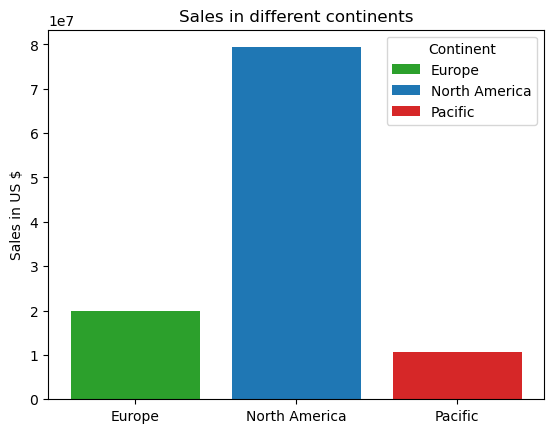

In [48]:
fig, ax = plt.subplots()

continents = sales_continent_df['Group']
sales = sales_continent_df['TotPerContinent']
bar_labels = continents
bar_colors = ['tab:green', 'tab:blue', 'tab:red']

ax.bar(continents, sales, label=bar_labels, color=bar_colors)

ax.set_ylabel('Sales in US $')
ax.set_title('Sales in different continents')
ax.legend(title='Continent')

plt.show()

In [15]:
sales_territory_df = pd.read_sql(sql="""select  a.TerritoryID, b.[Name], sum(Subtotal) as TotPerArea from Sales.SalesOrderHeader as a
inner join Sales.SalesTerritory as b on a.TerritoryID=b.TerritoryID
group by a.territoryID, b.[Name]""",con=connection)

In [16]:
sales_territory_df

,TerritoryID,Name,TotPerArea
0,9,Australia,1.065534e+07
1,3,Central,7.909009e+06
2,6,Canada,1.635577e+07
3,7,France,7.251556e+06
4,1,Northwest,1.608494e+07
5,10,United Kingdom,7.670721e+06
6,4,Southwest,2.418461e+07
7,5,Southeast,7.879655e+06
8,2,Northeast,6.939374e+06
9,8,Germany,4.915408e+06


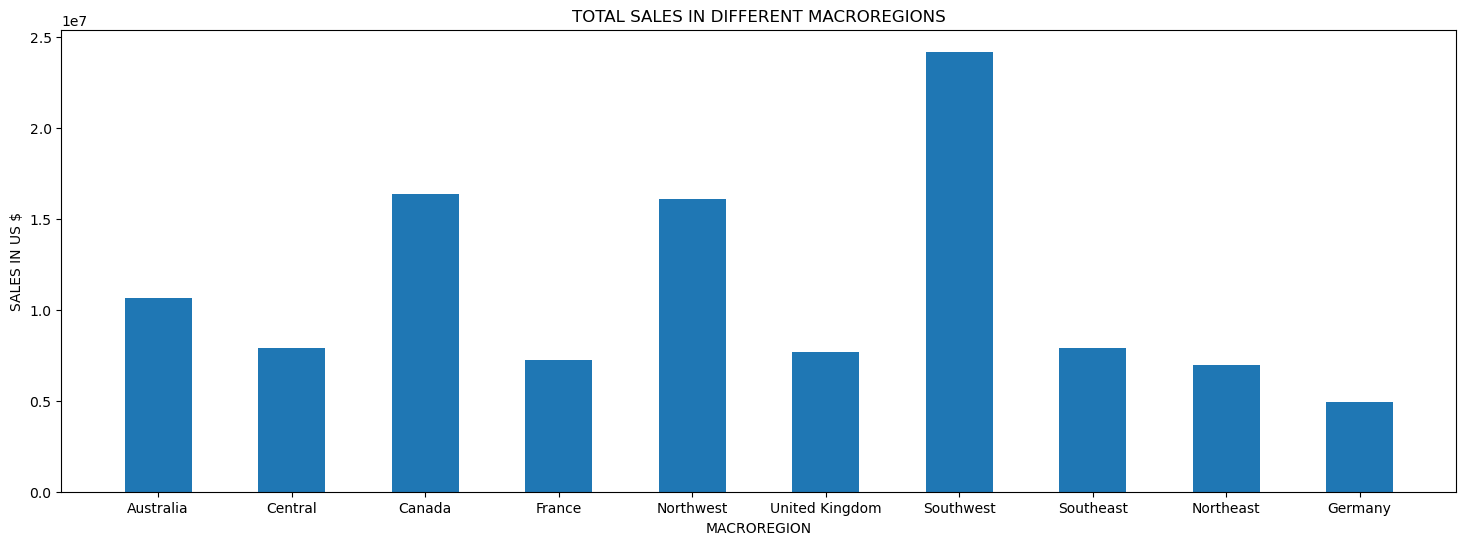

In [62]:
fig, ax = plt.subplots(figsize=(18,6))

territories = sales_territory_df['Name']
sales = sales_territory_df['TotPerArea']
ax.bar(territories, sales, width=0.5)

ax.set_ylabel('SALES IN US $')
ax.set_xlabel('MACROREGION')
ax.set_title('TOTAL SALES IN DIFFERENT MACROREGIONS')



plt.show()

In [292]:
sale_df = pd.read_sql(sql="""SELECT LineTotal
  FROM Sales.SalesOrderDetail""", con=connection)

In [294]:
sale_df.describe()

,LineTotal
count,121317.000000
mean,905.449207
std,1693.417389
min,1.374000
25%,24.990000
50%,134.982000
75%,1120.490000
max,27893.619000


In [63]:
most_sold_df = pd.read_sql(sql="""SELECT TOP 20 [Name], a.ProductID, sum(LineTotal) as Tot FROM Production.Product as a
INNER JOIN Sales.SalesOrderDetail as b on a.ProductID=b.ProductID
GROUP BY [Name], a.ProductID
ORDER BY Tot DESC""",con= connection)

In [54]:
most_sold_df

,Name,ProductID,Tot
0,"Mountain-200 Black, 38",782,4.400593e+06
1,"Mountain-200 Black, 42",783,4.009495e+06
2,"Mountain-200 Silver, 38",779,3.693678e+06
3,"Mountain-200 Silver, 42",780,3.438479e+06
4,"Mountain-200 Silver, 46",781,3.434257e+06
5,"Mountain-200 Black, 46",784,3.309673e+06
6,"Road-250 Black, 44",793,2.516857e+06
7,"Road-250 Black, 48",794,2.347656e+06
8,"Road-250 Black, 52",795,2.012448e+06
9,"Road-150 Red, 56",753,1.847819e+06


In [78]:
products= most_sold_df['ProductID']
print(products)
newList=[]
for number in products:
    numb = str(number)
    newList.append(numb)

0     782
1     783
2     779
3     780
4     781
5     784
6     793
7     794
8     795
9     753
10    976
11    749
12    969
13    973
14    792
15    966
16    751
17    957
18    796
19    789
Name: ProductID, dtype: int64


Text(0.5, 1.0, '20 most sold products')

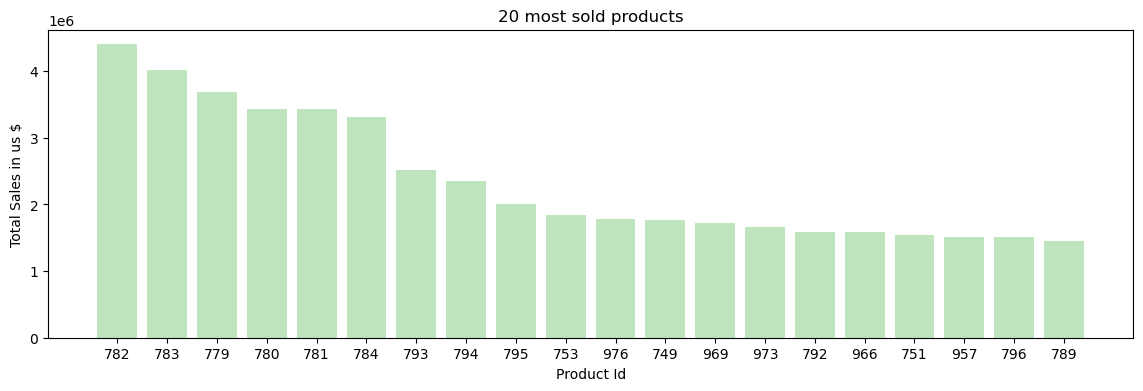

In [85]:
fig, ax = plt.subplots(figsize=(14,4))
ax.bar(newList, most_sold_df['Tot'], color= (0.5, 0.8, 0.5, 0.5))
ax.set_xlabel('Product Id')
ax.set_ylabel('Total Sales in us $')
ax.set_title('20 most sold products')
#plt.show()

In [70]:
most_sold2_df= pd.read_sql(sql="""SELECT [Name], a.ProductID, sum(LineTotal) as Tot FROM Production.Product as a
INNER JOIN Sales.SalesOrderDetail as b on a.ProductID=b.ProductID
GROUP BY [Name], a.ProductID
Having sum(LineTotal)>=1448122.478985""", con= connection)

In [71]:
most_sold2_df

,Name,ProductID,Tot
0,"Mountain-200 Black, 38",782,4.400593e+06
1,"Mountain-200 Black, 42",783,4.009495e+06
2,"Mountain-200 Black, 46",784,3.309673e+06
3,"Mountain-200 Silver, 38",779,3.693678e+06
4,"Mountain-200 Silver, 42",780,3.438479e+06
5,"Mountain-200 Silver, 46",781,3.434257e+06
6,"Road-150 Red, 48",751,1.540803e+06
7,"Road-150 Red, 56",753,1.847819e+06
8,"Road-150 Red, 62",749,1.769097e+06
9,"Road-250 Black, 44",793,2.516857e+06


In [80]:
most_sold2_df['ProductID']

0     782
1     783
2     784
3     779
4     780
5     781
6     751
7     753
8     749
9     793
10    794
11    795
12    796
13    789
14    792
15    973
16    976
17    966
18    969
19    957
Name: ProductID, dtype: int64

In [77]:
x=[]
for product in most_sold2_df['ProductID']:
    x.append(str(product))
print(x)

['782', '783', '784', '779', '780', '781', '751', '753', '749', '793', '794', '795', '796', '789', '792', '973', '976', '966', '969', '957']


In [82]:
y=most_sold2_df['Tot']

Text(0.5, 1.0, '20 most sold products')

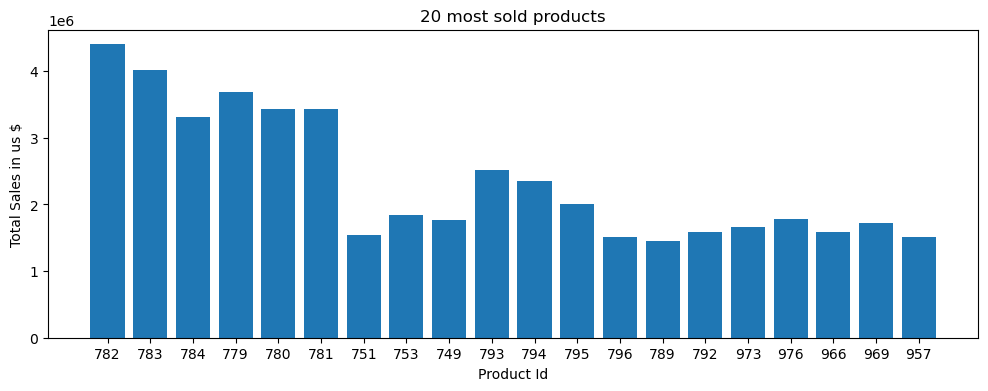

In [86]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(x,y)
ax.set_xlabel('Product Id')
ax.set_ylabel('Total Sales in us $')
ax.set_title('20 most sold products')